In [91]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os, sys
from astropy.stats import sigma_clip
from datetime import datetime
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(style='whitegrid')
from scipy.stats import norm
import warnings

### MASTER BIAS

In [2]:
pwd

'/home/jovyan/ASTR_136'

In [3]:
files_bias = os.listdir('BIAS/Stuff')

In [4]:
cd BIAS/Stuff

/home/jovyan/ASTR_136/BIAS/Stuff


In [5]:
vertical, horizontal = fits.open(files_bias[0])[0].data.shape
biasdata = np.zeros((vertical,horizontal,len(files_bias)))

for i in range(len(files_bias)):
    hdu = fits.open(files_bias[i])
    if not hdu[0].header['EXPTIME']:
        biasdata[:,:, i] = hdu[0].data

In [6]:
warnings.filterwarnings("ignore")

bias_master_mean = np.mean(biasdata, axis =2)
bias_master_median = np.median(biasdata, axis =2)
bias_std = np.std(biasdata, axis=2, keepdims=True)
biasdata_clipped = sigma_clip(biasdata)
bias_master = np.median(biasdata_clipped, axis=2)

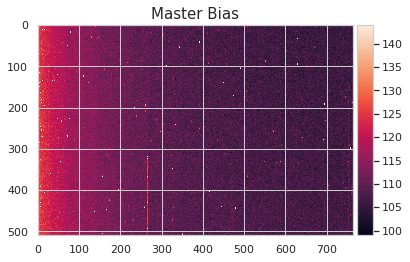

In [7]:
warnings.filterwarnings("ignore")

ax = plt.subplot(111)
im = ax.imshow(bias_master)
plt.title('Master Bias', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


plt.show()

### MASTER DARK

In [8]:
cd ../..

/home/jovyan/ASTR_136


In [9]:
files_dark = os.listdir('DARK')
dark_data = np.zeros((510,765,len(files_dark)))

In [10]:
cd DARK

/home/jovyan/ASTR_136/DARK


In [11]:
for i in range(len(files_dark)):
    hdu = fits.open(files_dark[i])
    if hdu[0].header['EXPTIME'] > 0:
        correct_dark = (hdu[0].data - bias_master)/hdu[0].header['EXPTIME']
        dark_data[:,:, i] = correct_dark

In [12]:
dark_mean = np.mean(dark_data, axis=2, keepdims=True)
dark_median = np.median(dark_data, axis=2, keepdims=True)
dark_std = np.std(dark_data, axis=2, keepdims=True)
dark_clipped = sigma_clip(dark_data)
dark_master = np.median(dark_clipped, axis=2)

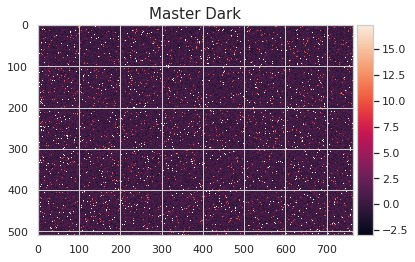

In [13]:
warnings.filterwarnings("ignore")

plt.imshow(dark_master)
ax = plt.subplot(111)
im = ax.imshow(dark_master)
plt.title('Master Dark', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

### MASTER FLAT

In [14]:
cd ..

/home/jovyan/ASTR_136


In [15]:
files_flat = [f for f in os.listdir('TWI/') if f.endswith('.fits')]
flat_data = np.zeros((510,765,len(files_flat)))

In [16]:
cd TWI

/home/jovyan/ASTR_136/TWI


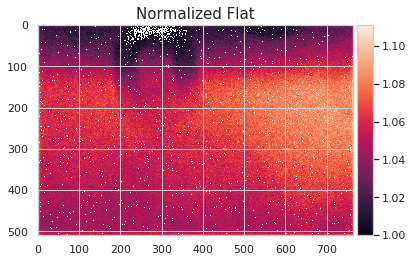

In [17]:
for i in range(len(files_flat)):
    hdu = fits.open(files_flat[i])
    if hdu[0].header['EXPTIME'] > 0:
        if hdu[0].header['APTDIA'] > 0:
            correct_flat = (((hdu[0].data - bias_master)/hdu[0].header['EXPTIME']) - dark_master)
            flat_clipped = sigma_clip(correct_flat)
            flat_min = np.amin(flat_clipped)
            flat_norm = (flat_clipped / flat_min)
            flat_data[:,:, i] = flat_norm



ax = plt.subplot(111)
im = ax.imshow(flat_norm)
plt.title('Normalized Flat', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


plt.show()

In [18]:
flat_mean = np.mean(flat_data, axis=2, keepdims=True)
flat_median = np.median(flat_data, axis=2, keepdims=True)
flat_std = np.std(flat_data, axis=2, keepdims=True)
flat_master = np.median(flat_data, axis=2)

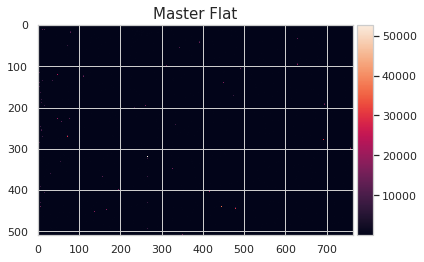

In [19]:
warnings.filterwarnings("ignore")
plt.imshow(flat_master)

ax = plt.subplot(111)
im = ax.imshow(flat_master)
plt.title('Master Flat', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


plt.show()

### MASTER SCIENCE

In [20]:
cd ..

/home/jovyan/ASTR_136


In [21]:
files_science = [f for f in os.listdir('SCIENCE') if f.endswith('.fits')]
science_data = np.zeros((510, 765, len(files_science)))

In [22]:
cd SCIENCE

/home/jovyan/ASTR_136/SCIENCE


In [23]:
obs_t_sci = []
for i in range(len(files_science)):
    hdu_sci = fits.open(files_science[i])
    header_sci = hdu_sci[0].header
    if header_sci['EXPTIME'] > 0:
        if header_sci['APTDIA'] > 0:
            correct_sci = (((hdu_sci[0].data - bias_master) /
                             header_sci['EXPTIME']) - dark_master
                             ) / flat_master
            science_data[:,:, i] = correct_sci
            
            time = header_sci['TIME-OBS']
            obs_t_sci += [time]   #or append. Just don't split to keep it as string

In [24]:

warnings.filterwarnings("ignore")

sci_clipped = sigma_clip(science_data)

sci_mean = []
sci_median = []
sci_std = []
for i in range(sci_clipped.shape[2]):
    mean = np.mean(sci_clipped[:,:,i])
    median = np.median(sci_clipped[:,:,i])
    std = np.std(sci_clipped[:,:,i])
    
    sci_mean.append(mean)
    sci_median.append(median)
    sci_std.append(std)

sci_median= np.array(sci_median)
sci_mean = np.array(sci_mean)


### CONVERTING TIME TO SECONDS

In [25]:
seconds = []
for i in range(len(obs_t_sci)):
    dt = datetime.strptime(obs_t_sci[i], '%H:%M:%S.%f')
    total_seconds = dt.second + dt.minute*60 + dt.hour*3600
    seconds.append(total_seconds)

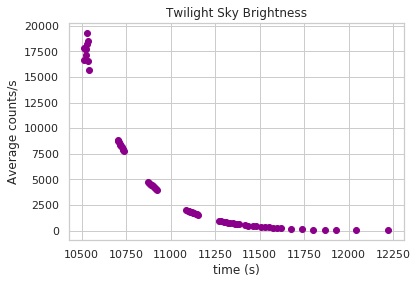

In [26]:
ax = plt.subplot(111)
plt.xlabel('time (s)') 
plt.ylabel('Average counts/s') 
plt.title('Twilight Sky Brightness')
plt.scatter(seconds, sci_median, label="projected" , color = 'darkmagenta')
plt.show()

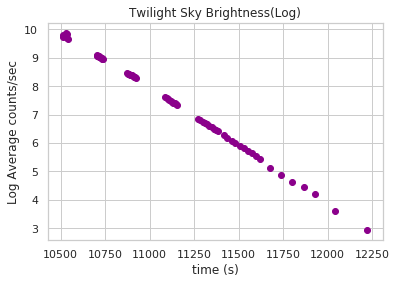

In [27]:
ax = plt.subplot(111)
y = np.log(sci_median)
y_new = np.log(sci_median)
plt.xlabel('time (s)') 
plt.ylabel('Log Average counts/sec') 
plt.title('Twilight Sky Brightness(Log)')
plt.scatter(seconds, y_new, label="projected" , color = 'darkmagenta')
plt.show()

### Fit The Data


In [28]:
y = np.log(sci_mean)
m, b = np.polyfit(seconds, y, 1)

In [29]:

# Linear function:
def func(x,m,b):
    f = []
    for i in x:
        y = m*i + b
        f.append(y)
    return f

In [30]:
y_fit = func(seconds,m,b)

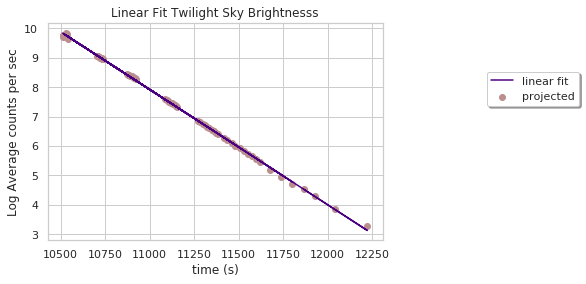

In [61]:
ax = plt.subplot(111)
plt.xlabel('time (s)') 
plt.ylabel('Log Average counts per sec') 
plt.title('Linear Fit Twilight Sky Brightnesss')
plt.scatter(seconds, y, label="projected" , color = 'rosybrown')
plt.plot(seconds, y_fit, label='linear fit', color='indigo')
#plt.savefig("Man.pdf")
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)

### Final Reduced Histogram

In [72]:
poo_poo = sci_clipped[:,:,60]

In [73]:
poo_poo.shape

(510, 765)

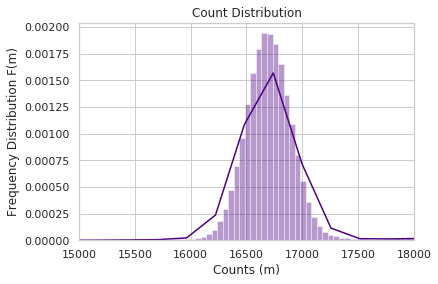

In [113]:
ax = sns.distplot(poo_poo.flatten(), bins = 500, color='indigo' )
plt.xlim(15000,18000)
plt.xlabel('Counts (m)') 
plt.ylabel('Frequency Distribution F(m)') 
plt.title('Count Distribution')
plt.show() 

### Observations

In [95]:
cd ..

/home/jovyan/ASTR_136


In [96]:
cd SCIENCE

/home/jovyan/ASTR_136/SCIENCE


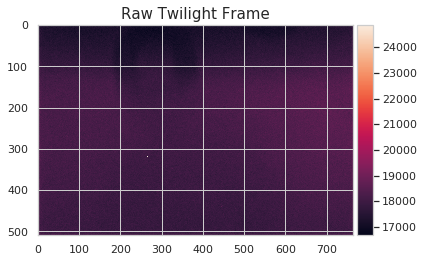

In [97]:

hdu_flat = fits.open("Project1_SB.00000089.fits")
example = hdu_flat[0].data

ax = plt.subplot(111)
im = ax.imshow(example)
plt.title('Raw Twilight Frame', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


plt.show()

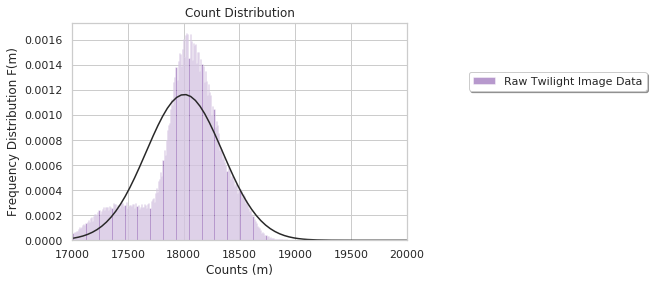

In [112]:
ax = sns.distplot(example.flatten(), fit = norm, bins = 'fd', color='indigo',kde=False, hist_kws={"label":"Raw Twilight Image Data"},kde_kws={"label":"Gaussian"})
plt.xlim(17000,20000)
plt.xlabel('Counts (m)') 
plt.ylabel('Frequency Distribution F(m)') 
plt.title('Count Distribution')
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.show() 

